In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pvlib.solarposition import get_solarposition
from sklearn.linear_model import LinearRegression

import traceback
from evidential import LinearNormalGamma, evidential_regresssion_loss
from tqdm import tqdm
import matplotlib
import torch, yaml
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import TensorDataset, Dataset
from torch.utils.data.dataloader import DataLoader
from mlsurfacelayer.data import load_derived_data
from sklearn.preprocessing import StandardScaler
from mlsurfacelayer.mo import mo_similarity
from collections import defaultdict

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [31]:
config_file = "surfacelayer/multi_output_cabauw.yaml"

In [241]:
with open(config_file, "r") as fid:
    config = yaml.load(fid, Loader=yaml.FullLoader)

In [242]:
data_file = config["data_file"]
train_test_split_date = pd.Timestamp(config["train_test_split_date"])
out_dir = "./surfacelayer"
output_types = config["output_types"]
input_columns = config["input_columns"]
output_columns = config["output_columns"]
output_column_list = [output_columns[output_type] for output_type in output_types]
derived_columns = config["derived_columns"]
model_configs = config["model_config"]
model_metric_types = config["model_metric_types"]
stability_column = config["stability_column"]

In [ ]:
data = load_derived_data(data_file, train_test_split_date, filter_counter_gradient=config["filter_counter_gradient"])

In [7]:
input_scaler, output_scaler = StandardScaler(), StandardScaler()
scaled_train_input = input_scaler.fit_transform(data["train"][input_columns])
scaled_train_output = output_scaler.fit_transform(data["train"][output_column_list])
scaled_test_input = input_scaler.transform(data["test"][input_columns])
scaled_test_output = output_scaler.transform(data["test"][output_column_list])

In [8]:
# pred_columns = []
# for output_type in output_types:
#     pred_columns.append(output_type + "-" + "mo")

# model_predictions = pd.DataFrame(0, index=data["test"].index,
#                                  columns=pred_columns + derived_columns + [*output_columns.values()],
#                                  dtype=np.float32)

# model_predictions.loc[:, derived_columns] = data["test"][derived_columns]

### Calculate Monin Obukhov

In [9]:
# for d, date in enumerate(data["test"].index):
#     mo_out = mo_similarity(data["test"].loc[date, "u_wind:10_m:m_s-1"],
#                            data["test"].loc[date, "v_wind:10_m:m_s-1"],
#                            data["test"].loc[date, "skin_temperature:0_m:K"],
#                            data["test"].loc[date, "temperature:10_m:K"],
#                            data["test"].loc[date, "skin_saturation_mixing_ratio:0_m:g_kg-1"] / 1000.0,
#                            data["test"].loc[date, "mixing_ratio:2_m:g_kg-1"] / 1000.0,
#                            data["test"].loc[date, "pressure:2_m:hPa"],
#                            mavail=data["test"].loc[date, "moisture_availability:soil:None"],
#                            z0=0.017,
#                            z10=10.0,
#                            z2=10.0)
#     for i, output_type in enumerate(output_types):
#         mo_string = output_type + '-mo'
#         if output_type != 'moisture_scale':
#             model_predictions.loc[date, mo_string] = mo_out[i]
#         else:
#             model_predictions.loc[date, mo_string] = mo_out[i] * 1000

In [243]:
input_size = len(input_columns)
output_size = len(output_column_list)

batch_size = config["model_config"]["neural_network"]["batch_size"]

L1_penalty = config["model_config"]["neural_network"]["l1_weight"]
L2_penalty = config["model_config"]["neural_network"]["l2_weight"]

lr_patience = 2
stopping_patience = 15
learning_rate = config["model_config"]["neural_network"]["lr"]

hidden_neurons = config["model_config"]["neural_network"]["hidden_neurons"]
hidden_layers = config["model_config"]["neural_network"]["hidden_layers"]
dropout = config["model_config"]["neural_network"]["dropout"]

In [244]:
train_dataset = TensorDataset(
    torch.from_numpy(scaled_train_input).float(),
    torch.from_numpy(scaled_train_output).float()
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_iter = iter(train_loader)

valid_dataset = TensorDataset(
    torch.from_numpy(scaled_test_input).float(),
    torch.from_numpy(scaled_test_output).float()
)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
valid_iter = iter(valid_loader)

In [248]:
model = nn.Sequential(
        nn.Linear(input_size, hidden_neurons),
        nn.BatchNorm1d(hidden_neurons),
        nn.Dropout(dropout),
        nn.LeakyReLU(),
        nn.Linear(hidden_neurons, hidden_neurons),
        LinearNormalGamma(hidden_neurons, output_size)
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = L2_penalty)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-2*learning_rate)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, 
#         patience = lr_patience, 
#         verbose = True,
#         min_lr = 1.0e-13
# )

In [249]:
results_dict = defaultdict(list)

for epoch in range(1000):
    
    # Train in batch mode
    #fiter =list(range(data['train'].shape[0] // batch_size))
    fiter = tqdm(range(data['train'].shape[0] // batch_size), leave=True)
    model.train()
    
    train_loss = []
    for t in fiter:

        try:
            x, y = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            x, y = next(train_iter)
            
        loss = evidential_regresssion_loss(y, (yy.cpu() for yy in model(x.to(device))), 1e-2)
        l1_norm = sum(p.abs().sum() for p in model.parameters()).cpu()
        loss += L1_penalty * l1_norm
        train_loss.append(loss.item())

        fiter.set_description(f"Epoch {epoch} train_loss {np.mean(train_loss):.4f} lr {optimizer.param_groups[0]['lr']:.8f}")
        fiter.update()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lr_scheduler.step()
        
    # Validate in batch mode
    model.eval()
    with torch.no_grad():
        valid_loss = []
        #fiter = list(range(data['test'].shape[0] // batch_size))
        fiter = tqdm(list(range(data['test'].shape[0] // batch_size)), leave=True)
        for t in fiter:

            try:
                x, y = next(valid_iter)
            except StopIteration:
                valid_iter = iter(valid_loader)
                x, y = next(valid_iter)
            loss = evidential_regresssion_loss(y, (yy.cpu() for yy in model(x.to(device))), 1e-2)
            valid_loss.append(loss.item())
            
            fiter.set_description(f"Epoch {epoch} valid_loss {np.mean(valid_loss):.4f}")
            fiter.update()
            
    results_dict["epoch"].append(epoch)
    results_dict["train_nll"].append(np.mean(train_loss))
    results_dict["val_nll"].append(np.mean(valid_loss))
    results_dict["lr"].append(optimizer.param_groups[0]['lr'])
    
    # Save the dataframe to disk
    df = pd.DataFrame.from_dict(results_dict).reset_index()
    df.to_csv(f"surfacelayer/training_log.csv", index = False)
    
#     print(f'Epoch {epoch} train_nll {results_dict["train_nll"][-1]:4f}', 
#           f'val_nll {results_dict["val_nll"][-1]:4f}',
#           f'lr {results_dict["lr"][-1]}'
#          )

    # anneal the learning rate using just the box metric
    #lr_scheduler.step(results_dict["val_nll"][-1])
    
    if results_dict["val_nll"][-1] == min(results_dict["val_nll"]):
        state_dict = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': min(results_dict["val_nll"])
        }
        torch.save(state_dict, f"surfacelayer/mlp.pt")
    
    # Stop training if we have not improved after X epochs
    best_epoch = [i for i,j in enumerate(results_dict["val_nll"]) if j == min(results_dict["val_nll"])][0]
    offset = epoch - best_epoch
    if offset >= stopping_patience:
        break

Epoch 29 train_loss 0.2131 lr 0.00000010:  59%|█████▉    | 2330/3949 [00:10<00:07, 222.38it/s]


KeyboardInterrupt: 

### Load the best model and predict

In [250]:
checkpoint = torch.load(
    "surfacelayer/mlp.pt",
    map_location=lambda storage, loc: storage
)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [303]:
true_results = []
mean_results = []
var_results = []
train_loss = []

train_loader2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
train_iter2 = iter(train_loader2)

model.eval()
with torch.no_grad():
    fiter = list(range(data['train'].shape[0] // batch_size + 1))
    #fiter = tqdm(list(range(data['test'].shape[0] // batch_size)), leave=True)
    for t in fiter:
        try:
            x, y = next(train_iter2)
        except StopIteration:
            train_iter2 = iter(train_iter2)
            x, y = next(train_iter2)
        
        gamma, v, alpha, beta = [yy.cpu() for yy in model(x.to(device))]
        loss = evidential_regresssion_loss(y, [gamma, v, alpha, beta], 1e-2)
        train_loss.append(loss.item())
        mean_results.append(gamma.numpy())
        var_results.append(np.sqrt(beta.cpu().numpy() / (v.cpu().numpy() * (alpha.cpu().numpy() - 1))))
        true_results.append(y.numpy())

train_nll = np.array([[x] for x in train_loss])
train_true_results = np.vstack(true_results)
train_mean_results = np.vstack(mean_results)
train_var_results = np.vstack(var_results)

In [304]:
true_results = []
mean_results = []
var_results = []
ev_results = []
valid_loss = []
model.eval()
with torch.no_grad():
    fiter = list(range(data['test'].shape[0] // batch_size + 1))
    #fiter = tqdm(list(range(data['test'].shape[0] // batch_size)), leave=True)
    for t in fiter:
        try:
            x, y = next(valid_iter)
        except StopIteration:
            valid_iter = iter(valid_loader)
            x, y = next(valid_iter)
        
        gamma, v, alpha, beta = [yy.cpu() for yy in model(x.to(device))]
        loss = evidential_regresssion_loss(y, [gamma, v, alpha, beta], 1e-2)
        valid_loss.append(loss.item())
        mean_results.append(gamma.numpy())
        var_results.append(np.sqrt(beta.cpu().numpy() / (v.cpu().numpy() * (alpha.cpu().numpy() - 1))))
        true_results.append(y.numpy())
        ev_results.append(np.array([gamma.numpy(), v.numpy(), alpha.numpy(), beta.numpy()]))

valid_nll = np.array([[x] for x in valid_loss])
valid_true_results = np.vstack(true_results)
valid_mean_results = np.vstack(mean_results)
valid_var_results = np.vstack(var_results)
#ev_results = np.concatenate([x.transpose(1,2,0) for x in ev_results])

In [350]:
true_results = np.vstack([train_true_results, valid_true_results])
mean_results = np.vstack([train_mean_results, valid_mean_results])
var_results = np.vstack([train_var_results, valid_var_results])

In [345]:
def plot_predictions(train_times, y_train, test_times, y_test, mu, var, n_stds=4, kk=0, total_times = None):
    #x_test = x_test[:, 0]
    fig = plt.figure(figsize=(10, 6), dpi=200)
    
    for kk in range(2):
        ax = fig.add_subplot(1, 2, kk+1)
        ax.scatter(train_times, y_train[:, kk], s=1., c='#463c3c', zorder=5, label="Train")
        ax.plot(test_times, y_test[:, kk], 'r--', zorder=2, label="True")
        ax.plot(total_times, mu[:, kk], color='#007cab', zorder=3, label="Pred")

        for k in np.linspace(0, n_stds, 4):
            ax.fill_between(
                total_times, (mu[:, kk] - k * var[:, kk]), (mu[:, kk] + k * var[:, kk]),
                alpha=0.3,
                edgecolor=None,
                facecolor='#00aeef',
                linewidth=0,
                zorder=0,
                label="Unc." if k == 0 else None)
        
        if kk == 0:
            ax.set_ylim(-1., 2.)
        else:
            ax.set_ylim(-0.2, 0.25)
        ax.set_xlim(3.105, 3.11)
        ax.legend(loc="best")
        ax.set_xlabel("Seconds since 2003 / 1e8")
        ax.set_ylabel(output_types[kk])
        ax.ticklabel_format(style='sci', axis='x', scilimits=(-3,3))
    
    plt.tight_layout()
    plt.show()

In [314]:
t0 = data["train"].index[0].to_pydatetime()
train_times = [(x-t0).total_seconds() / 1e8 for x in data["train"].index]
test_times = [(x-t0).total_seconds() /1e8 for x in data["test"].index]
total_times = [(x-t0).total_seconds() /1e8 for x in list(data["train"].index) + list(data["test"].index)]

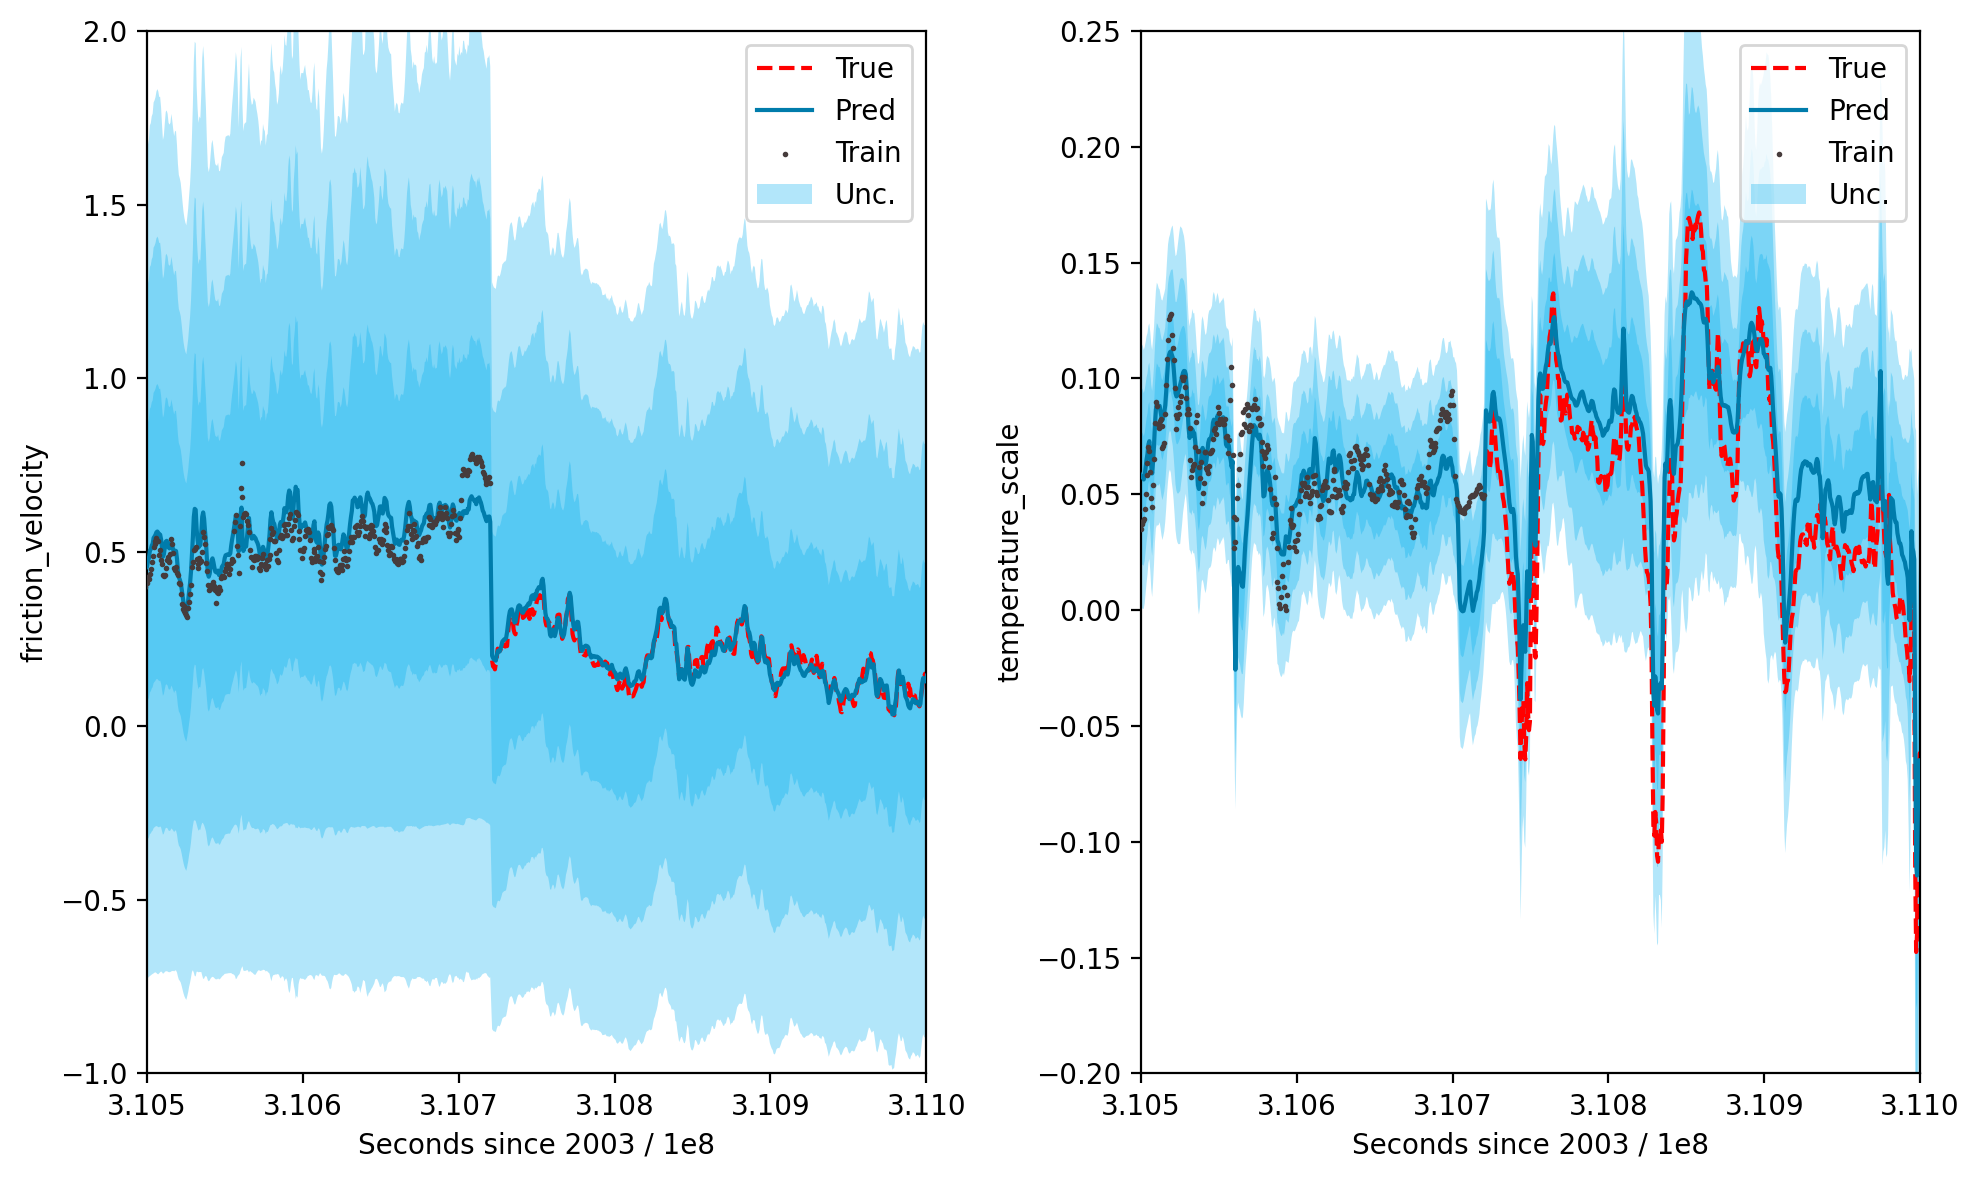

In [351]:
plot_predictions(
    train_times,
    output_scaler.inverse_transform(train_true_results), 
    test_times,
    output_scaler.inverse_transform(valid_true_results),
    output_scaler.inverse_transform(mean_results), 
    output_scaler.inverse_transform(var_results), 
    n_stds=4, 
    kk=0, 
    total_times = total_times)

In [387]:
mae = valid_true_results - valid_mean_results

(0.0, 2.0)

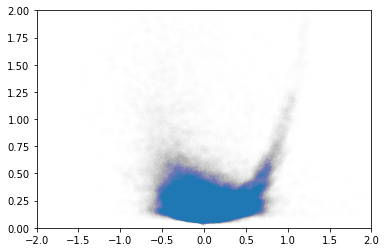

In [388]:
plt.scatter(mae[:, 0], valid_var_results[:, 0], alpha = 0.002)
plt.xlim([-2, 2])
plt.ylim([0, 2])

(0.0, 3.0)

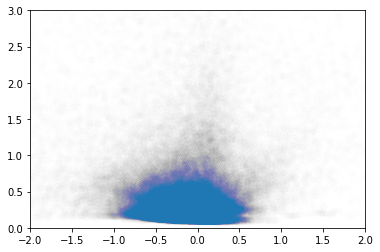

In [389]:
plt.scatter(mae[:, 1], valid_var_results[:, 1], alpha = 0.002)
plt.xlim([-2, 2])
plt.ylim([0, 3])